In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, backtest, v_backtester
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
multi_periods = [25, 50, 100]
multiplier = 20
threshold = 1
bankroll = 15000
smooth = int(np.ceil(periods/4))

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
contract = contract.loc['20180202':]
#contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180430']
#contract = contract.loc['20190101': '20190410']

In [4]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

10116.65626191967

In [5]:
vol_candles = group_by_volume(contract, avg_vol)
#vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume
label,,,,,,,
0,2018-02-02 01:49:00,6954.00,6963.50,6941.00,6941.75,5242,10045
1,2018-02-02 03:59:00,6941.50,6946.25,6912.50,6939.00,5798,10297
2,2018-02-02 08:10:00,6938.50,6944.00,6925.25,6934.50,5947,10143
3,2018-02-02 10:02:00,6934.00,6935.25,6889.75,6892.00,5731,10153
4,2018-02-02 11:01:00,6891.75,6897.75,6865.75,6867.50,5696,10293
...,...,...,...,...,...,...,...
17402,2019-09-04 17:14:00,7678.50,7686.75,7678.25,7680.75,5355,10544
17403,2019-09-04 17:31:00,7681.00,7696.00,7679.50,7696.00,5002,10577
17404,2019-09-04 17:50:00,7696.00,7703.00,7695.50,7700.50,5423,11277


In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [7]:
def breakout(data, periods, smooth):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / data['breakout'].rolling(periods).std()
    data[f'breakout_{periods}'] = data['breakout_norm'].ewm(span=smooth).mean()
    return data[f'breakout_{periods}']

In [8]:
def carver(data, periods, smooth):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'breakout_{periods}'] = data['breakout_norm'].ewm(span=smooth).mean()
    return data[f'breakout_{periods}']

In [9]:
def ema(data, periods, smooth):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    return data[f'ema_{periods}']

In [10]:
def ema_1(data, periods, smooth):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    data[f'ema_{periods}'] = data['ema_diff'].ewm(span=smooth).mean()
    return data[f'ema_{periods}']

In [11]:
def roc(data, periods, smooth):
    data.copy()
    data['roc'] = (data.close / data.close.shift(periods)) -1
    data['roc_norm'] = data.roc / data.roc.rolling(periods).std()
    data[f'roc_{periods}'] = data['roc_norm'].ewm(span=smooth).mean()
    return data[f'roc_{periods}']

In [12]:
def rsi(data, periods, smooth):
    data = data.copy()
    data['change'] = data['close'] - data['close'].shift(1)
    data['up'] = (data['change'] > 0) * data['change']
    data['down'] = ((data['change'] < 0) * data['change']).abs()
    data['rs'] = data['up'].ewm(span=periods, min_periods=periods*.9).mean() / data['down'].ewm(span=periods, min_periods=periods*.9).mean()
    data['rsi'] = (100 - (100 / (1 + data['rs'])))
    data['rsi_smooth'] = data['rsi'].ewm(span=smooth).mean()
    data['rsi_mod'] = data['rsi'] - 50
    signals = ((data['rsi_smooth'] > 75) * -20) + ((data['rsi_smooth'] < 25) * 20)
    return signals

In [13]:
def combine(data, periods, funcs):
    data = data.copy()
    for func in funcs:
        for p in periods:
            s = func(data, p, smooth)
            data[s.name] = s
    data = data.iloc[3*max(periods):]
    return data

In [14]:
breakouts = pd.DataFrame([breakout(data, p, smooth) for p in multi_periods]).T.mean(axis=1)
emas = pd.DataFrame([ema(data, p, smooth) for p in multi_periods]).T.mean(axis=1)
rocs = pd.DataFrame([roc(data, p, smooth) for p in multi_periods]).T.mean(axis=1)
rsis = pd.DataFrame([rsi(data, p, smooth) for p in multi_periods]).T.mean(axis=1)
carvers = pd.DataFrame([carver(data, p, smooth) for p in multi_periods]).T.mean(axis=1)
emas_1 = pd.DataFrame([ema_1(data, p, smooth) for p in multi_periods]).T.mean(axis=1)
forecasts = pd.DataFrame(
    {'date': data.date,
     'open': data.open,
     'close': data.close,
     'breakout': breakouts,
     'ema': emas,
     'roc': rocs,
     'rsi': rsis,
     'carver': carvers,
     'ema_1': emas_1}
     ).iloc[periods*3:]
forecasts

,date,open,close,breakout,ema,roc,rsi,carver,ema_1
label,,,,,,,,,
300,2018-02-08 18:39:00,6460.50,6450.25,-1.362622,-1.431021,-1.242702,0.0,-0.334523,-21.183853
301,2018-02-08 18:46:00,6449.75,6432.25,-1.453785,-1.515849,-1.325601,0.0,-0.347252,-22.680679
302,2018-02-08 18:53:00,6431.75,6402.75,-1.559966,-1.603606,-1.435232,0.0,-0.359002,-24.288778
303,2018-02-08 18:58:00,6402.50,6406.25,-1.648170,-1.692189,-1.529955,0.0,-0.368711,-25.972475
304,2018-02-08 19:05:00,6405.75,6420.75,-1.700702,-1.779346,-1.608125,0.0,-0.372814,-27.675872
...,...,...,...,...,...,...,...,...,...
17402,2019-09-04 17:14:00,7678.50,7680.75,0.460075,0.250039,0.484496,0.0,0.112646,7.661941
17403,2019-09-04 17:31:00,7681.00,7696.00,0.508387,0.339523,0.571411,0.0,0.122825,8.167142
17404,2019-09-04 17:50:00,7696.00,7700.50,0.551771,0.430152,0.669479,0.0,0.133408,8.686208


In [15]:
forecasts[['breakout', 'ema', 'roc', 'rsi']].corr()

,breakout,ema,roc,rsi
breakout,1.000000,0.597523,0.964506,-0.098656
ema,0.597523,1.000000,0.693419,-0.023618
roc,0.964506,0.693419,1.000000,-0.085288
rsi,-0.098656,-0.023618,-0.085288,1.000000


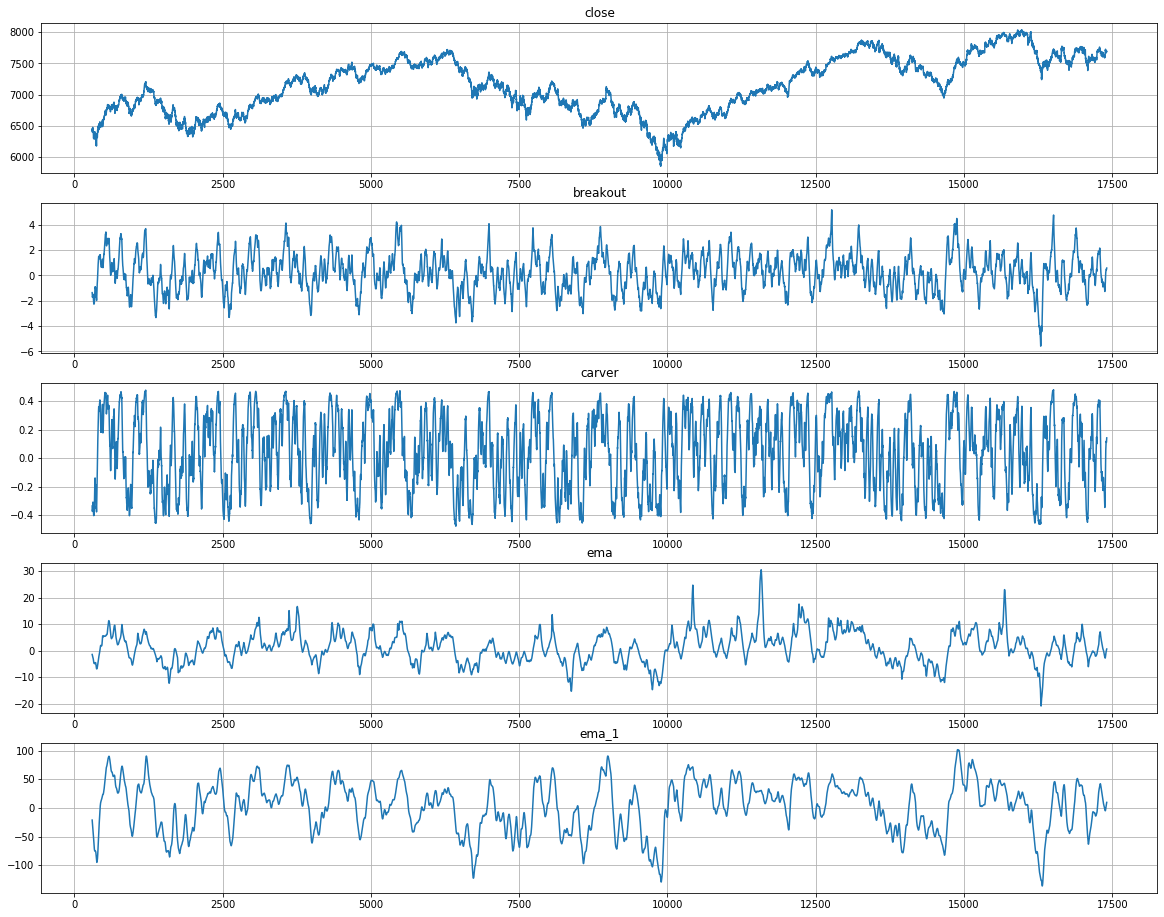

In [16]:
plot(forecasts[['close','breakout','carver', 'ema', 'ema_1']])

In [17]:
forecasts['breakout'].mean()

0.22776353933586957

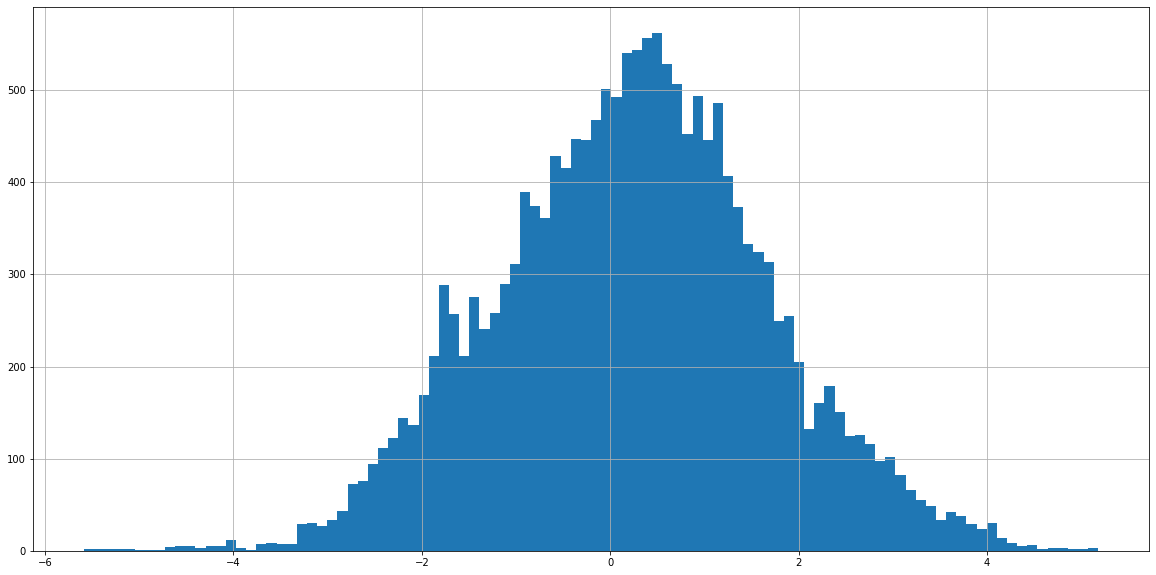

In [18]:
forecasts['breakout'].hist(figsize=(20,10), bins=100);

In [19]:
10 / forecasts[['breakout', 'ema', 'carver', 'ema_1', 'rsi']].abs().mean()

breakout      8.583093
ema           2.174598
carver       45.287736
ema_1         0.282282
rsi         777.590909
dtype: float64

In [20]:
scaled = pd.DataFrame({'date': forecasts.date,
                      'open': forecasts.open,
                      'close': forecasts.close,
                      'breakout': (forecasts.breakout * 8.5).clip(lower=-20, upper=20),
                      'ema': (forecasts.ema * 2.2).clip(lower=-20, upper=20),
                      'rsi': (forecasts.rsi * 42).clip(lower=-20, upper=20),
                       'carver': (forecasts.carver * 43).clip(lower=-20, upper=20),
                      'ema_1': (forecasts.ema_1 * .24).clip(lower=-20, upper=20)})

In [21]:
scaled[['breakout', 'ema', 'rsi', 'carver', 'ema_1']].corr()

,breakout,ema,rsi,carver,ema_1
breakout,1.000000,0.626578,-0.074511,0.973764,0.616292
ema,0.626578,1.000000,-0.027900,0.541590,0.931519
rsi,-0.074511,-0.027900,1.000000,-0.073541,-0.039176
carver,0.973764,0.541590,-0.073541,1.000000,0.513854
ema_1,0.616292,0.931519,-0.039176,0.513854,1.000000


In [22]:
#scaled['combined'] = scaled[['breakout',]].mean(axis=1)
scaled['combined'] = scaled[['breakout', 'ema',]].mean(axis=1)
#scaled['combined'] = scaled[['carver', 'ema_1',]].mean(axis=1)

In [23]:
scaled['combined'].std()

9.967539990755606

In [24]:
10/scaled['combined'].std()

1.0032565717593809

In [25]:
scaled['combined'] = (scaled['combined'] * 1)

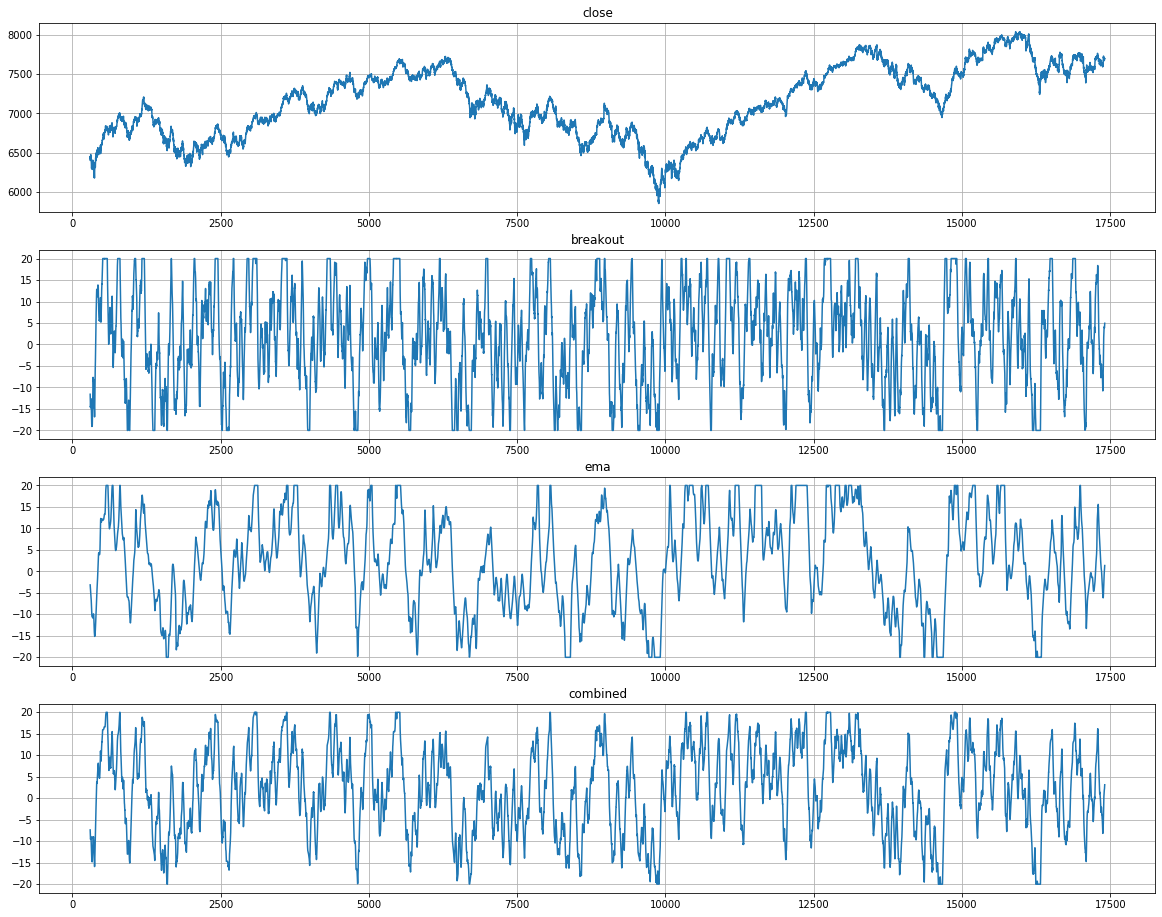

In [26]:
plot(scaled[['close', 'breakout', 'ema', 'combined']])

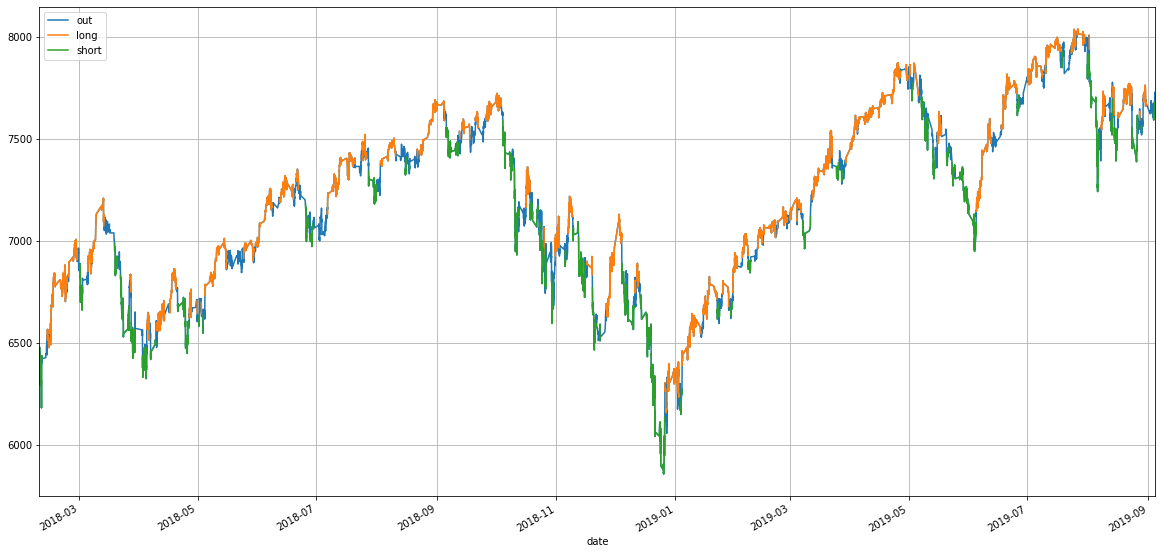

In [27]:
chart_data = scaled.set_index('date')
chart_price(chart_data.close, chart_data['combined'], 5)

In [28]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
for i in [0, 5, 10, 15]:
    r = v_backtester(chart_data.open,
                   chart_data.combined, 
                   i, multiplier, bankroll, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance

In [29]:
stats

,0,5,10,15
Annual return,0.32597,0.743795,0.376509,-0.490131
Cumulative returns,0.584333,1.47667,0.684,-0.666667
Annual volatility,1.72352,0.726938,0.816742,3.06742
Sharpe ratio,0.915504,1.12127,0.781412,0.545786
Calmar ratio,0.37307,1.86895,1.09863,-0.519044
Stability,0.0711108,0.815897,0.738713,0.601613
Max drawdown,-0.87375,-0.397975,-0.342707,-0.944296
Omega ratio,1.21974,1.22449,1.18568,1.31835
Sortino ratio,1.68021,1.86382,1.38046,1.80403
Skew,3.06711,0.691851,1.45859,12.1833


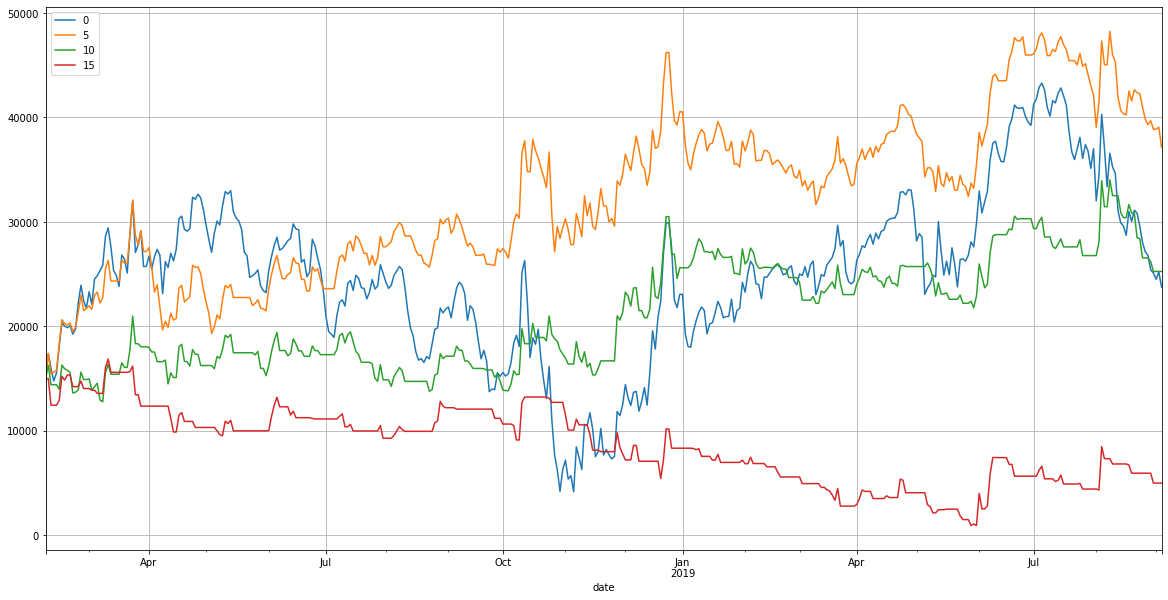

In [30]:
dailys.plot(figsize=(20,10), grid=True);

In [31]:
five = v_backtester(chart_data.open,
                   chart_data.combined, 
                   5, multiplier, bankroll, False)

In [32]:
five.positions

,date_o,open,date_c,close,pnl,pnl_dollars,duration
0,2018-02-08 18:46:00,-6449.75,2018-02-09 21:58:00,6426.75,23.00,460.0,1 days 03:12:00
1,2018-02-12 19:57:00,6514.25,2018-02-13 16:47:00,-6518.75,4.50,90.0,0 days 20:50:00
2,2018-02-13 20:05:00,6547.75,2018-02-22 20:03:00,-6766.00,218.25,4365.0,8 days 23:58:00
3,2018-02-23 17:15:00,6825.25,2018-02-28 04:52:00,-6915.75,90.50,1810.0,4 days 11:37:00
4,2018-03-01 16:02:00,-6817.00,2018-03-01 16:45:00,6884.50,-67.50,-1350.0,0 days 00:43:00
...,...,...,...,...,...,...,...
147,2019-08-23 17:40:00,-7559.00,2019-08-26 15:10:00,7558.25,0.75,15.0,2 days 21:30:00
148,2019-08-27 16:02:00,7632.00,2019-08-27 17:32:00,-7575.25,-56.75,-1135.0,0 days 01:30:00
149,2019-08-28 15:53:00,-7534.00,2019-08-28 16:42:00,7562.00,-28.00,-560.0,0 days 00:49:00
150,2019-08-29 15:32:00,7686.25,2019-08-30 21:26:00,-7664.75,-21.50,-430.0,1 days 05:54:00


In [34]:
five.positions.sort_values('pnl_dollars').head(25)

,date_o,open,date_c,close,pnl,pnl_dollars,duration
143,2019-08-12 20:54:00,-7539.25,2019-08-13 15:51:00,7745.50,-206.25,-4125.0,0 days 18:57:00
65,2018-10-26 13:49:00,-6780.25,2018-10-26 18:53:00,6953.25,-173.00,-3460.0,0 days 05:04:00
88,2019-01-02 19:30:00,6384.00,2019-01-03 07:46:00,-6230.25,-153.75,-3075.0,0 days 12:16:00
117,2019-05-03 17:26:00,7836.75,2019-05-06 03:21:00,-7688.00,-148.75,-2975.0,2 days 09:55:00
64,2018-10-25 21:03:00,7063.00,2018-10-25 22:43:00,-6918.75,-144.25,-2885.0,0 days 01:40:00
14,2018-04-04 13:10:00,-6324.50,2018-04-04 18:00:00,6463.25,-138.75,-2775.0,0 days 04:50:00
86,2018-12-26 22:52:00,6302.75,2018-12-27 12:42:00,-6169.00,-133.75,-2675.0,0 days 13:50:00
11,2018-03-27 14:18:00,6830.50,2018-03-27 18:42:00,-6722.25,-108.25,-2165.0,0 days 04:24:00
144,2019-08-13 17:20:00,7730.00,2019-08-14 15:00:00,-7622.50,-107.50,-2150.0,0 days 21:40:00
140,2019-08-01 18:01:00,8006.75,2019-08-01 19:37:00,-7900.25,-106.50,-2130.0,0 days 01:36:00


In [35]:
five.df

,price,indicator,signal,position,transaction,curr_price,base_price,pnl,c_transaction,o_transaction,pnl_dollars,cum_pnl_dollars,balance
date,,,,,,,,,,,,,
2018-02-08 18:39:00,6460.50,-7.365267,-1,0,0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,15000.0
2018-02-08 18:46:00,6449.75,-7.846018,-1,-1,-1,0.00,0.00,0.00,-0.0,-1.0,0.0,0.0,15000.0
2018-02-08 18:53:00,6431.75,-8.393821,-1,-1,0,-6431.75,-6449.75,18.00,0.0,0.0,360.0,360.0,15360.0
2018-02-08 18:58:00,6402.50,-8.866132,-1,-1,0,-6402.50,-6431.75,29.25,0.0,0.0,585.0,945.0,15945.0
2018-02-08 19:05:00,6405.75,-9.185266,-1,-1,0,-6405.75,-6402.50,-3.25,0.0,0.0,-65.0,880.0,15880.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-04 17:14:00,7678.50,2.230362,0,0,0,0.00,0.00,0.00,-0.0,0.0,0.0,22150.0,37150.0
2019-09-04 17:31:00,7681.00,2.534121,0,0,0,0.00,0.00,0.00,-0.0,0.0,0.0,22150.0,37150.0
2019-09-04 17:50:00,7696.00,2.818195,0,0,0,0.00,0.00,0.00,-0.0,0.0,0.0,22150.0,37150.0
